### IMPORTS

In [87]:
import numpy as np
import pandas as pd
import pickle as pkl
import csv
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import itertools


### ATIVAÇÕES

In [88]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)



def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

### FUNÇÕES DE CUSTO

In [89]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return -(np.mean(y*np.log(y_pred) + (1 - y)*(np.log(1 - y_pred))))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        -(y - y_sigmoid) / y.shape[0]
    return -(np.mean(y*np.log(y_sigmoid) + (1 - y)*(np.log(1 - y_sigmoid))))

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

### INICIALIZAÇÕES

In [90]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0 / rows + cols)
    return 2 * limit * np.random.rand(rows, cols) - limit

### REDE

In [91]:
class Layer():
    def __init__(self, input_dim, output_dim, weights_initializer=random_normal, bias_initializer=ones, activation=linear):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = bias_initializer(1, output_dim)
        self.activation = activation


        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0

class NeuralNetwork():
    def __init__(self, cost_func=sigmoid_cross_entropy, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate

    def fit(self, x_train, y_train, epochs=100, verbose=10):
        for epoch in range(epochs + 1):
            y_pred = self.__feedforward(x_train)
            self.__backprop(y_train, y_pred)

            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                print("epochs: {0:=4}/{1} loss_train: {2:.8f}".format(epoch, epochs, loss_train))

    def predict(self, x):
        return self.__feedforward(x)

    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)

    def load(file_path):
        return pkl.load(open(file_path, 'rb'))

    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out


    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate * layer._dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases


### DATA

In [92]:
#train_data = pd.read_csv("mnist_train.csv")
#test_data = pd.read_csv("mnist_test.csv")
#data.head()

with open("mnist_train.csv") as train_data:
    train_list = list(itertools.islice(train_data, 1001))

'''test_data = open("mnist_test.csv")
test_list = test_data.readlines()
test_data.close()'''

print(len(train_list))
#print(len(test_list))


1001


In [93]:

x, y = [], []

for line in train_list[1:]:
    values = line.split(",")
    label = int(values[0])

    image_array = np.asfarray(values[1:]).reshape((28,28))
    
    x.append(image_array.flatten())
    y.append(label)

    #plt.figure()
    #plt.imshow(image_array, cmap="Greys", interpolation="None")
    #plt.show()

x = np.asarray(x)
y = np.asarray(y).reshape(-1, 1)
'''
for line in train_list[1:]:
    values = line.split(",")
    label = int(values[0])
    image_data = np.from
    '''

print(x.shape[1], y.shape[1])

onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot)

784 1
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [150]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=64, activation=sigmoid, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=64, output_dim=64, activation=sigmoid))
nn.layers.append(Layer(input_dim=64, output_dim=64, activation=sigmoid))
nn.layers.append(Layer(input_dim=64, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=100)

nn.save('modelnpNN.pkl')

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

epochs:    0/2000 loss_train: 7.28152877
epochs:  100/2000 loss_train: 0.94241211
epochs:  200/2000 loss_train: 0.65877043
epochs:  300/2000 loss_train: 0.59761902
epochs:  400/2000 loss_train: 0.57948836
epochs:  500/2000 loss_train: 0.53215861
epochs:  600/2000 loss_train: 0.51020475
epochs:  700/2000 loss_train: 0.48985869
epochs:  800/2000 loss_train: 0.47023204
epochs:  900/2000 loss_train: 0.45443601
epochs: 1000/2000 loss_train: 0.43968452
epochs: 1100/2000 loss_train: 0.42642941
epochs: 1200/2000 loss_train: 0.41597031
epochs: 1300/2000 loss_train: 0.40531628
epochs: 1400/2000 loss_train: 0.39359709
epochs: 1500/2000 loss_train: 0.38566780
epochs: 1600/2000 loss_train: 0.37770999
epochs: 1700/2000 loss_train: 0.36992751
epochs: 1800/2000 loss_train: 0.36041656
epochs: 1900/2000 loss_train: 0.35188024
epochs: 2000/2000 loss_train: 0.34543694
Acurácia: 91.80%


In [151]:
def random_image():
    with open('mnist_test.csv') as test:
        reader = csv.reader(test)
        chosen_row = random.choice(list(reader))
    return chosen_row

In [152]:
def test():
    row = random_image()
    #print(row)

    tlabel = int(row[0])
    test_image_array =  np.asfarray(row[1:]).reshape((28, 28))
    #print(test_image_array)
    print("Image:")
    plt.figure()
    plt.imshow(test_image_array, cmap="Greys", interpolation="None")
    plt.show()

    print(f"\nLabel: {tlabel}")

    x, y = [], []

    x.append(test_image_array.flatten())
    y.append(tlabel)

    x = np.asarray(x)
    y = np.asarray(y).reshape(-1, 1)

    #print(x.shape[1], y.shape[1])

    onehot = OneHotEncoder(sparse_output=False)
    y_onehot = onehot.fit_transform(y)
    #print(y_onehot)

    nn = NeuralNetwork.load('modelnpNN.pkl')
    predicted_class = np.argmax(nn.predict(x), axis=1)

    print(f"predict: {predicted_class}")

    if tlabel == predicted_class:
        print("\033[1;32mPREDICTION CORRECT")
    else:
        print("\033[1;31mPREDICTION ICORRECT")

Image:


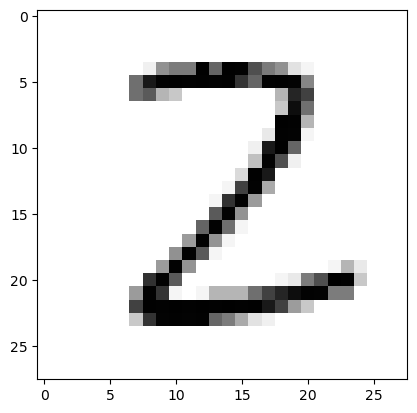


Label: 2
predict: [2]
PREDICTION CORRECT


In [163]:
test()